Train Neural Networks to estimate Likelihood Ratios
===

In this notebook we will setup the neural networks that train unbiased and low-variance density ratios to be then used for inference. 

In [1]:
import os, sys, pathlib, importlib
sys.path.append('../')

# Load the package and modules for training and plotting
import nsbi_common_utils
from nsbi_common_utils import plotting, training, datasets, configuration
from nsbi_common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle
import yaml
import random

from utils import preselection_using_score, calculate_preselection_observable

from coffea.analysis_tools import PackedSelection

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

/home/jsandesara_umass_edu/NSBI-workflow-tutorial/src/nsbi_common_utils/plotting.py:11: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-10-14 09:25:16.961362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-14 09:25:16.983518: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-14 09:25:16.990283: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-14 09:25:17.007637: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CP

In [2]:
importlib.reload(sys.modules['nsbi_common_utils.configuration'])
from nsbi_common_utils import configuration

config = nsbi_common_utils.configuration.ConfigManager(file_path_string = './config.yml')


In [3]:
# Input features for training
features, features_scaling = config.get_training_features()

Statistical Model
-

The statistical model we have is: 

$$p(x|\mu, \alpha) = \frac{1}{\nu(\mu, \alpha)} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot p_c\left(x|\alpha\right)$$

where $c$ stands for the various physics channels that contribute to the final state $x$, **$\mu$ is the signal-strength parameter and $\alpha$ is the vector of nuisance parameters associated with the various systematic uncertainties in the model**. Note that we are assuming that the parameter $\mu$-dependence is known analytically and that we have simulation models for each of the channels $p_c(x)$. 

Setting up the test
-

The objective is to build the test statistic for composite hypothesis testing:

$$t_\mu = -2 \cdot \frac{\text{Pois}(\mathcal{N}_\text{evts}|\mu, \hat{\hat{\alpha}})}{\text{Pois}(\mathcal{N}_\text{evts}|\hat{\mu}, \hat{\alpha})} -2 \cdot \sum_i^{\mathcal{N}_\text{evts}} w_i \times \log \frac{p(x_i|\mu, \hat{\hat{\alpha}})}{p(x_i|\hat{\mu}, \hat{\alpha})} + \sum_m^{N_\text{systs}} \alpha_m^2$$

A direct approach would then be to model the probability density $p(x|\mu, \alpha)$ using NNs. But that is a more difficult task than training probability density ratios. We use a simple trick:

$$t_\mu = -2 \cdot \frac{\text{Pois}(\mathcal{N}_\text{evts}|\mu, \hat{\hat{\alpha}})}{\text{Pois}(\mathcal{N}_\text{evts}|\hat{\mu}, \hat{\alpha})} -2 \cdot \sum_i^{\mathcal{N}_\text{evts}} w_i \times \log \frac{p(x_i|\mu, \hat{\hat{\alpha}})/p_{ref}(x)}{p(x_i|\hat{\mu}, \hat{\alpha})/p_{ref}(x)} + \sum_m^{N_\text{systs}} \alpha_m^2$$


to turn this into a density ratio estimation problem:

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\nu(\mu, \alpha)} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot \frac{p_c\left(x|\alpha\right)}{p_{ref}(x)}$$

Factorizing out the $\alpha$-dependence in the density ratios:

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha)\cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

Factorized approach:
--

Instead of training NNs parameterized on $\mu$ and $\alpha$, we use analytical parameterizations to simplify the problem to training only parameter-independent density ratios.

Let's set this up for the toy $H\to \tau\tau$ model we are using. **Neglecting the nuisance parameter dependence ($G_c(\alpha) = g_c(x|\alpha) = 1$), the probability model can be written as** 

$$\sum_c f_c(\mu) \cdot \nu_c(\mu) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)} = \mu \cdot \nu_{H \to \tau\tau}(\mu) \cdot  \frac{p_{H \to \tau\tau}\left(x\right)}{p_{ref}(x)} + \nu_{t\bar{t}}(\mu) \cdot  \frac{p_{t\bar{t}}\left(x\right)}{p_{ref}(x)} + \nu_{Z \to \tau\tau}(\mu) \cdot  \frac{p_{Z \to \tau\tau}\left(x\right)}{p_{ref}(x)}$$

In the NSBI approach presented in this tutorial, the density ratio estimation as a function of the various nuisance parameters is factorized from the nominal density ratio estimation, and will be done in the  `Systematic_Uncertainty_Estimation.ipynb` notebook.

In [4]:
importlib.reload(sys.modules['nsbi_common_utils.datasets'])
from nsbi_common_utils import datasets

branches_to_load = features + ['presel_score']

Datasets = nsbi_common_utils.datasets.datasets(config_path = './config.yml',
                                                branches_to_load =  branches_to_load)

In [5]:
dataset_incl_dict      = Datasets.load_datasets_from_config(load_systematics = False)

dataset_incl_nominal   = dataset_incl_dict["Nominal"].copy()

dataset_SR_nominal     = Datasets.filter_region_dataset(dataset_incl_nominal,
                                                       region = "SR")

Density ratio training
===

Now we train the NNs for $\frac{p_c}{p_{ref}}(x)$ density ratios to build the full model. Our choice of reference hypothesis, motivated by the search-oriented mixture model described above, would be: 

$$p_{ref}(x) = p_{H \to \tau\tau}(x) = \frac{1}{\nu_{H \to \tau\tau}} \frac{d\sigma_{H \to \tau\tau}}{dx} $$

gives the POI $\mu-$parameterized model:

$$\sum_c \left[f_c(\mu) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)} \right]= \mu + \frac{p_{t\bar{t}}\left(x\right)}{p_{H \to \tau\tau}(x)} + \frac{p_{Z \to \tau\tau}\left(x\right)}{p_{H \to \tau\tau}(x)}$$

But this has shown to cause numerical issues, since the ratio corresponding to the $\mu$-scaling signal term is exactly 1. In the absence of additional signal production mechansims, we instead use:

$$p_{ref}(x) = \frac{1}{\nu_{H \to \tau\tau} + \nu_{t\bar{t}}} \left[\frac{d\sigma_{H \to \tau\tau}}{dx} + \frac{d\sigma_{t\bar{t}}}{dx} \right]$$

giving a more numerically stable model:

$$\sum_c \left[f_c(\mu) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)} \right]= \mu \cdot \frac{p_{H \to \tau\tau}\left(x\right)}{p_{ref}(x)} + \frac{p_{t\bar{t}}\left(x\right)}{p_{ref}(x)} + \frac{p_{Z \to \tau\tau}\left(x\right)}{p_{ref}(x)}$$

The task of estimating the $\mu-$parameterized density ratio is thus reduced to estimating three $\mu-$independent density ratios $\frac{p_{H \to \tau\tau}}{p_{ref}}(x)$, $\frac{p_{t\bar{t}}}{p_{ref}}(x)$ and $\frac{p_{Z \to \tau\tau}}{p_{ref}}(x)$ mixed together with an analytical parameterization (hence the name mixture model).

**NB**: This is the same as the *morphing-aware* approach of density ratio estimation in MadMiner

In [6]:
# Define the processes that make up the mixture model formula for density ratio estimation

PATH_TO_SAVED_DATA = './saved_data/'
TRAINING_OUTPUT_PATH = f'{PATH_TO_SAVED_DATA}output_training_nominal/'

# Signal processes in the model
basis_processes = config.get_basis_samples()
print(basis_processes)

ref_processes = config.get_reference_samples()
print(ref_processes)


['htautau', 'ttbar', 'ztautau']
['htautau', 'ttbar']


In [7]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import TrainEvaluate_NN

ref_train_label_sample_dict = {**{ref: 0 for ref in ref_processes}}

dataset_ref     = Datasets.merge_dataframe_dict_for_training(dataset_SR_nominal, 
                                                            ref_train_label_sample_dict, 
                                                            samples_to_merge = ref_processes)

NN_training_mix_model = {}

use_log_loss = False

# DELETE_EXISTING_MODELS = True
DELETE_EXISTING_MODELS = False

path_to_ratios = {}
path_to_figures = {}
path_to_models = {}

for process_type in basis_processes:

    # Get the dictionary of labels to processes
    _train_label_sample_dict = {process_type        : 1}

    dataset_num     = Datasets.merge_dataframe_dict_for_training(dataset_SR_nominal, 
                                                                _train_label_sample_dict, 
                                                                samples_to_merge = [process_type])

    # Build a training dataset for the training of p_<process_type>/p_<ref_processes> density ratio
    dataset_mix_model = pd.concat([dataset_num, dataset_ref])

    # Save paths
    output_name                     = f'{process_type}'
    output_dir                      = f'{TRAINING_OUTPUT_PATH}general_output_{process_type}'
    path_to_ratios[process_type]    = f'{TRAINING_OUTPUT_PATH}output_ratios_{process_type}/'
    path_to_figures[process_type]   = f'{TRAINING_OUTPUT_PATH}output_figures_{process_type}/'
    path_to_models[process_type]    = f'{TRAINING_OUTPUT_PATH}output_model_params_{process_type}/'

    NN_training_mix_model[process_type] = TrainEvaluate_NN(dataset_mix_model, 
                                                           dataset_mix_model['weights_normed'].to_numpy(),
                                                           dataset_mix_model['train_labels'].to_numpy(),
                                                           features, 
                                                           features_scaling, 
                                                           [process_type, 'ref'], 
                                                            output_dir, output_name, 
                                                            path_to_figures=path_to_figures[process_type],
                                                            path_to_ratios=path_to_ratios[process_type], 
                                                            path_to_models=path_to_models[process_type],
                                                            use_log_loss = use_log_loss,
                                                            delete_existing_models = DELETE_EXISTING_MODELS)


    del dataset_mix_model


Neural Network architecture
===

Here we will start with a multi-layer perceptron (simple feed-forward Neural Network with fully-connected layers). This can be supplemented with more complex architectures like transformers. 

After detailed tuning during the off-shell Higgs boson analysis effort, we found that a network with very wide layers ($\geq 1000$) and a depth of less than 10 works best - alongside batch size of a few hundreds and a gradually declining learning rate that starts with a value just large enough to not blow up.

Starting with the training and validation of the various density ratio:

$$\frac{p_{H\to\tau\tau}(x)}{p_\text{ref}(x)}, \frac{p_{t\bar{t}}(x)}{p_\text{ref}(x)}, \frac{p_{Z \to \tau\tau}(x)}{p_\text{ref}(x)}$$

In [8]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [9]:
# You can either train your own NNs (in which case set this to False) or you can load the pre-trained NNs. 
# Training NNs without GPUs can be very slow, for the kind of NNs we need for unbiased estimation of density ratios
USE_SAVED_MODELS = True

# Define unique settings for each process type
doCalibration = False
RECALIBRATE = False
num_bins_cal = 50
scaling_type = 'MinMax'
batch_size = 512
validation_split = 0.1
holdout_split = 0.25

num_epochs = 100
callback_patience = 30

num_layers = 4
num_neurons_per_layer = 1000

num_ensemble_members = 20

verbose_level = 0

PLOT_SCALED_FEATURES = False

training_settings = {

    'htautau': {
        'hidden_layers':        num_layers,
        'neurons':              num_neurons_per_layer,
        'number_of_epochs':     num_epochs,
        'batch_size':           batch_size,
        'learning_rate':        0.1,
        'scalerType':           scaling_type,
        'calibration':          doCalibration,
        'num_bins_cal':         num_bins_cal,
        'callback':             True,
        'callback_patience':    callback_patience,
        'callback_factor':      0.01,
        'validation_split':     validation_split,
        'holdout_split':        holdout_split,
        'verbose':              verbose_level,
        'plot_scaled_features': PLOT_SCALED_FEATURES,
        'load_trained_models':  USE_SAVED_MODELS,
        'recalibrate_output'   : RECALIBRATE,
        'num_ensemble_members': num_ensemble_members
    },
    
    'ttbar': {
        'hidden_layers':        num_layers,
        'neurons':              num_neurons_per_layer,
        'number_of_epochs':     num_epochs,
        'batch_size':           batch_size,
        'learning_rate':        0.1,
        'scalerType':           scaling_type,
        'calibration':          doCalibration,
        'num_bins_cal':         num_bins_cal,
        'callback':             True,
        'callback_patience':    callback_patience,
        'callback_factor':      0.01,
        'validation_split':     validation_split,
        'holdout_split':        holdout_split,
        'verbose':              verbose_level,
        'plot_scaled_features': PLOT_SCALED_FEATURES,
        'load_trained_models':  USE_SAVED_MODELS,
        'recalibrate_output'   : RECALIBRATE,
        'num_ensemble_members': num_ensemble_members
    },
    
    'ztautau': {
        'hidden_layers':        num_layers,
        'neurons':              num_neurons_per_layer,
        'number_of_epochs':     num_epochs,
        'batch_size':           batch_size,
        'learning_rate':        0.1,
        'scalerType':           scaling_type,
        'calibration':          doCalibration,
        'num_bins_cal':         num_bins_cal,
        'callback':             True,
        'callback_patience':    callback_patience,
        'callback_factor':      0.01,
        'validation_split':     validation_split,
        'holdout_split':        holdout_split,
        'verbose':              verbose_level,
        'plot_scaled_features': PLOT_SCALED_FEATURES,
        'load_trained_models':  USE_SAVED_MODELS,
        'recalibrate_output'   : RECALIBRATE,
        'num_ensemble_members': num_ensemble_members
    }
}

In [10]:
# Train the density ratio NN
for process_type in basis_processes:
    
    settings = training_settings[process_type]

    NN_training_mix_model[process_type].train_ensemble(**settings)
    NN_training_mix_model[process_type].test_normalization()
    

starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 1
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 2
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 3
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 4
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 5
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 6
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 7
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 8
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 9
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 10
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 11
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 12
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 13
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 14
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 15
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 16
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 17
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 18
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 19
Reading saved models from ./saved_data/output_training_nominal/output_model_params_htautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0034721837107727




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 1 is 1.0018861178353191




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 2 is 0.9994004510519539




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 3 is 1.0046153622992944




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 4 is 1.001144910921842




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 5 is 1.0031701246910725




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 6 is 1.001587272167841




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 7 is 1.003272929521969




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 8 is 1.0015979056135638




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 9 is 0.9993141409768604




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 10 is 1.002452863606339




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 11 is 1.003410352987799




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 12 is 1.0036963948403945




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 13 is 1.0027284996624015




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 14 is 1.0042295888039112




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 15 is 1.0023650943762898




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 16 is 1.0004854663790577




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 17 is 1.0021582797828517




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 18 is 1.0010062872318963




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 19 is 1.0052449444826312


The sum of PDFs using the whole ensemble is 1.0023619585472032



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 1
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 2
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 3
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 4
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 5
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 6
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 7
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 8
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 9
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 10
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 11
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 12
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 13
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 14
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 15
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 16
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 17
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 18
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 19
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ttbar/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 0.9999356290713913




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 1 is 1.0021054347444056




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 2 is 1.0009552410492246




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 3 is 1.002219735338918




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 4 is 1.0046142257977984




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 5 is 0.9986051157971738




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 6 is 1.0019104326904458




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 7 is 1.0009852226670872




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 8 is 1.0012421247717846




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 9 is 0.9986212542971131




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 10 is 1.0009746301251954




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 11 is 0.9991594322468283




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 12 is 1.0004560693282514




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 13 is 0.9981198870710107




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 14 is 1.0017315263006161




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 15 is 1.0026173749303675




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)







The sum of PDFs in ensemble member 17 is 1.000441608732921




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)







The sum of PDFs in ensemble member 19 is 1.0001073186630138


The sum of PDFs using the whole ensemble is 1.0008521287573535



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 1
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 2
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 3
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 4
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 5
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 6
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 7
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 8
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 9
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 10
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 11
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 12
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 13
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 14
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 15
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 16
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 17
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 18
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Loading existing model for ensemble member 19
Reading saved models from ./saved_data/output_training_nominal/output_model_params_ztautau/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)







The sum of PDFs in ensemble member 1 is 0.9986042678454837




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 2 is 0.9984020371469609




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 3 is 1.0045470595074075




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 4 is 1.0051647300306592




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 5 is 1.0007560310663302




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 6 is 0.9997285623015052




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 7 is 1.0013375113721295




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 8 is 1.000310822321759




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 9 is 1.0053731872597524




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)







The sum of PDFs in ensemble member 11 is 0.9971156288738364




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 12 is 1.001072202587752




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 13 is 1.0001286272387366




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)







The sum of PDFs in ensemble member 15 is 1.0005554996337225




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 16 is 0.9976528261950606




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 17 is 0.9981165624864717




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 18 is 1.0038304378620175




IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 19 is 0.998145540406215


The sum of PDFs using the whole ensemble is 1.0001428339783245





Check for overtraining by comparing the NN output distributions between training and holdout datasets. The holdout dataset is the subset of events not used during training.

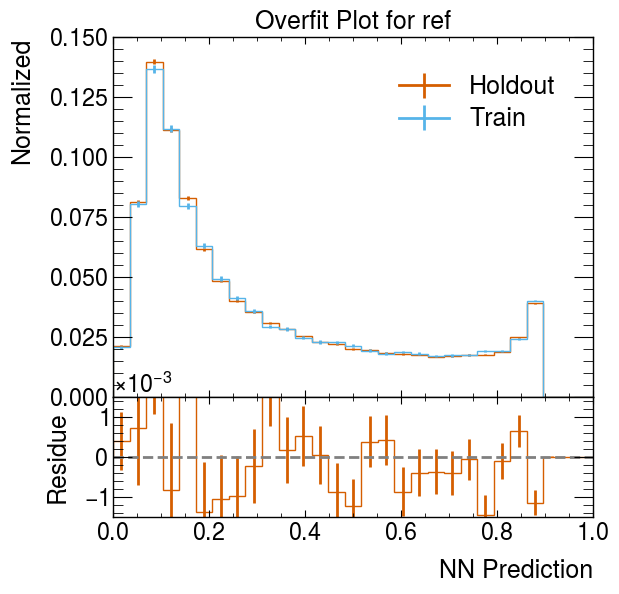

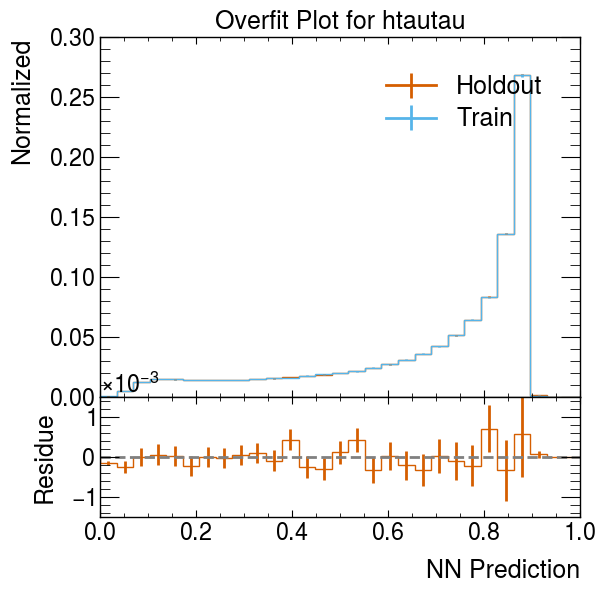

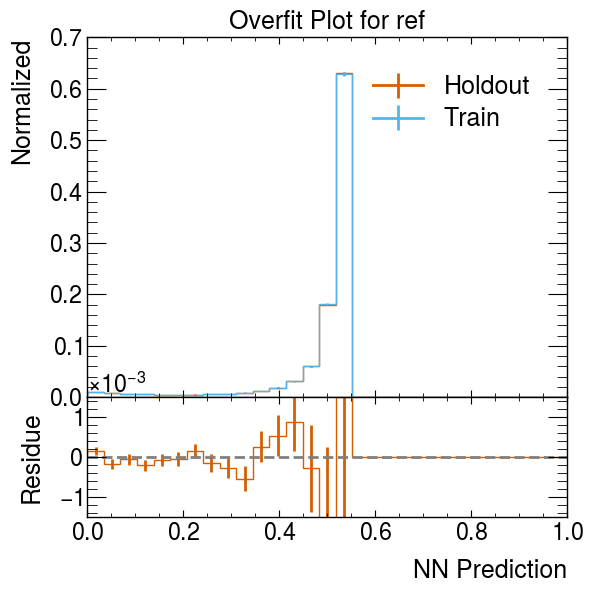

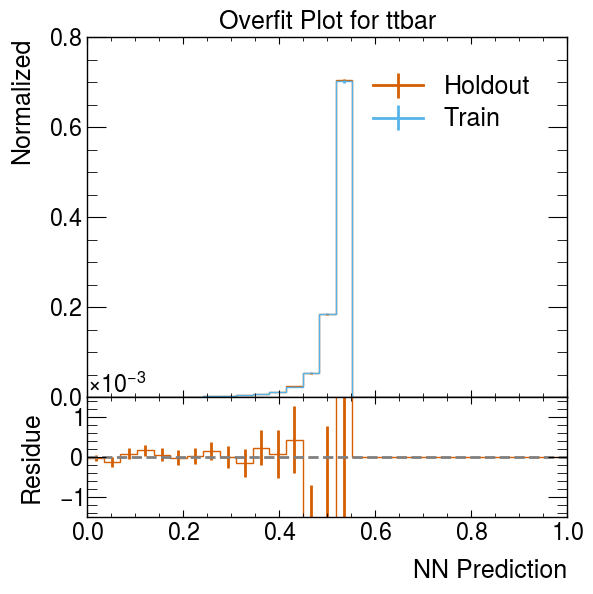

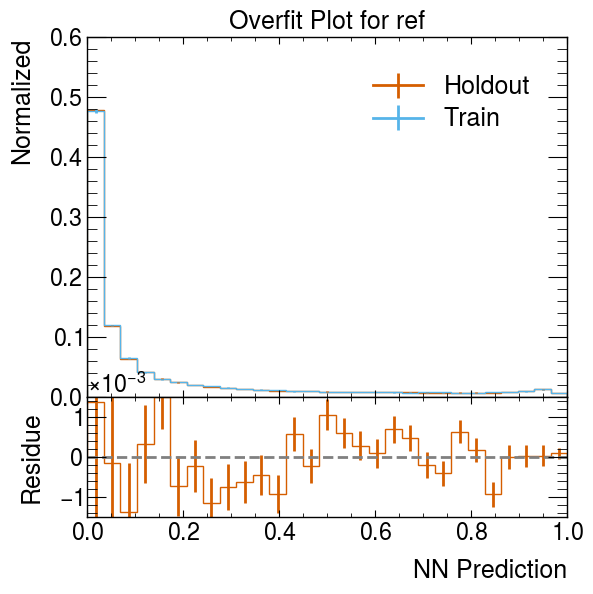

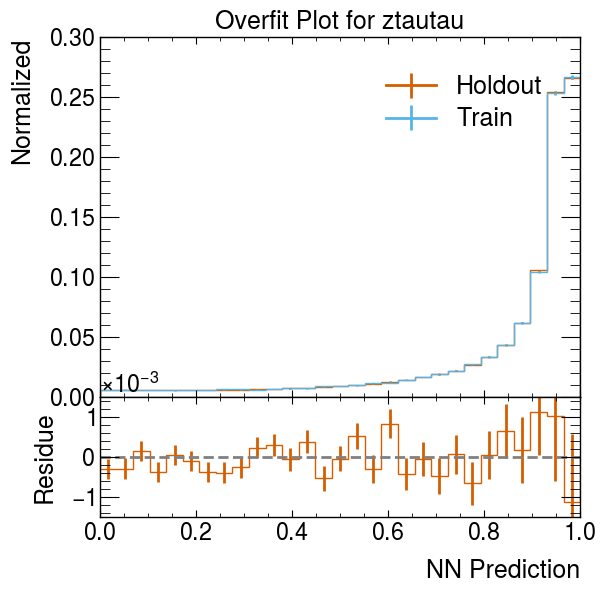

<Figure size 800x600 with 0 Axes>

In [11]:
for process_type in basis_processes:
    NN_training_mix_model[process_type].make_overfit_plots()

Diagnostic Checks
===

While traditionally, a NN observable is judged on the basis of its accuracy - for NSBI we are interested in the quality of the density ratios more than the discrimination power. The latter comes from the perfect modelling of the multi-dimensional likelihood ratios.

To ensure correct modelling, we run two main checks on the training:

- **Calibration closure test**

  The NNs are trained using the binary cross-entropy loss, which under ideal conditions leads to the NN converging to the score function:

  $$\hat{s}_\text{pred} = \frac{p_\text{ref}(x)}{p_\text{ref}(x)+p_\text{c}(x)}$$

  that can be converted into the probability ratio we desire (likelihood ratio trick):

  $$\frac{p_\text{c}(x)}{p_\text{ref}(x)} = \frac{\hat{s}_\text{pred}(x)}{1-\hat{s}_\text{pred}(x)}$$

  For the NNs to be well-calibrated, we use the Monte Carlo samples to verify the equality:


  $$\left[\frac{p_c(x)}{p_c(x)+p_{ref}(x)}\right]_\text{NN} \sim \left[\frac{\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}}{\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}+\mathcal{N}_\text{ref}^{I(x|\hat{s}_\text{pred})}}\right]_\text{MC}$$

  where we bin the events from $p_c$ and $p_\text{ref}$ MC samples, denoted by $\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}$ and $\mathcal{N}_\text{ref}^{I(x|\hat{s}_\text{pred})}$ respectively where $I(x|\hat{s}_\text{pred})$ returns the index of the $\hat{s}_\text{pred}$ bin in which an event $x$ falls.
 


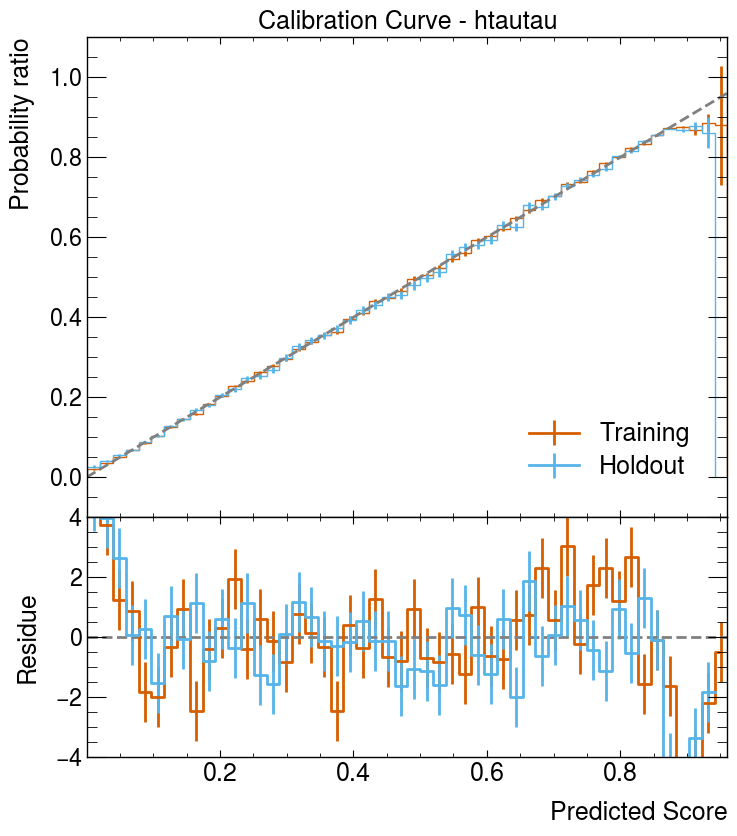

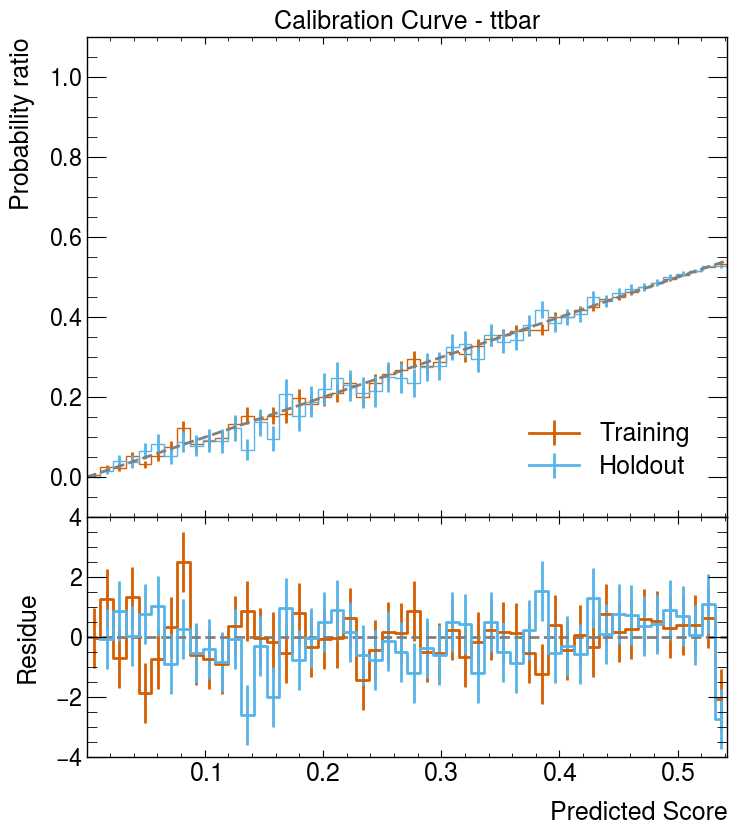

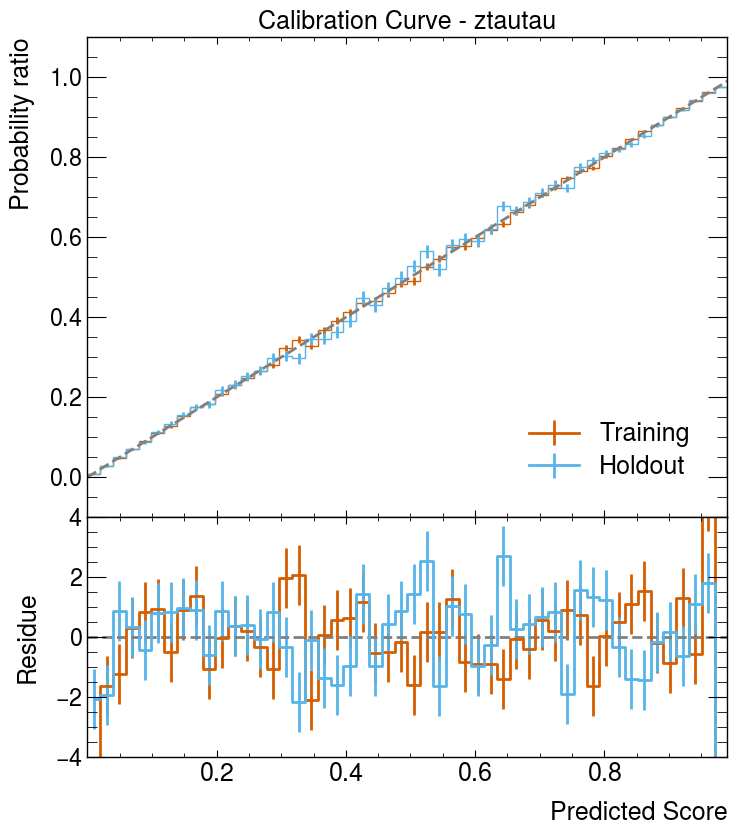

<Figure size 800x600 with 0 Axes>

In [12]:
num_bins_cal = 50

for process_type in basis_processes:
    NN_training_mix_model[process_type].make_calib_plots(nbins=num_bins_cal, observable='score')

## Density ratio reweighting closure tests
  
  Despite having a well-calibrated output and thus a robust probabilistic interpretation, the trained density ratios might not capture the full multi-dimensional event information $x$. In other words, the NNs might still be biased estimators of the optimal score function, as defined in the CARL paper (link).

  The next diagnostic involves verifying the following equality using 1D projections of $x$:

  $$\frac{p_c(x)}{p_{ref}(x)} \times p_{ref}(x) \sim p_c(x)$$

  We can do this one-by-one for all the observables used to model the density ratios, and also possibly the observables not used directly in the training but can still be well-estimated due to the NN learning the right physics.

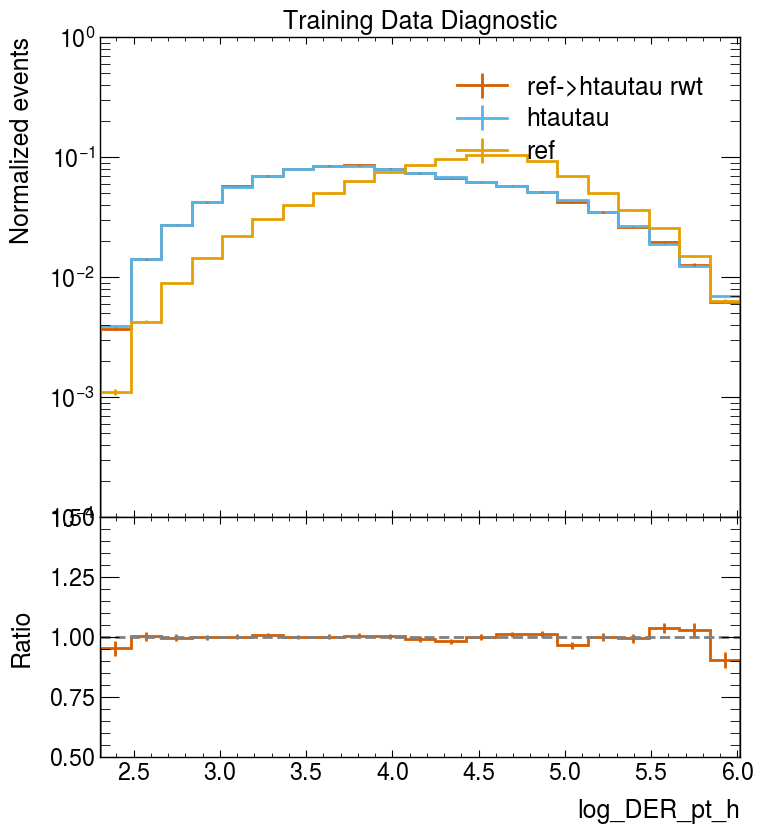

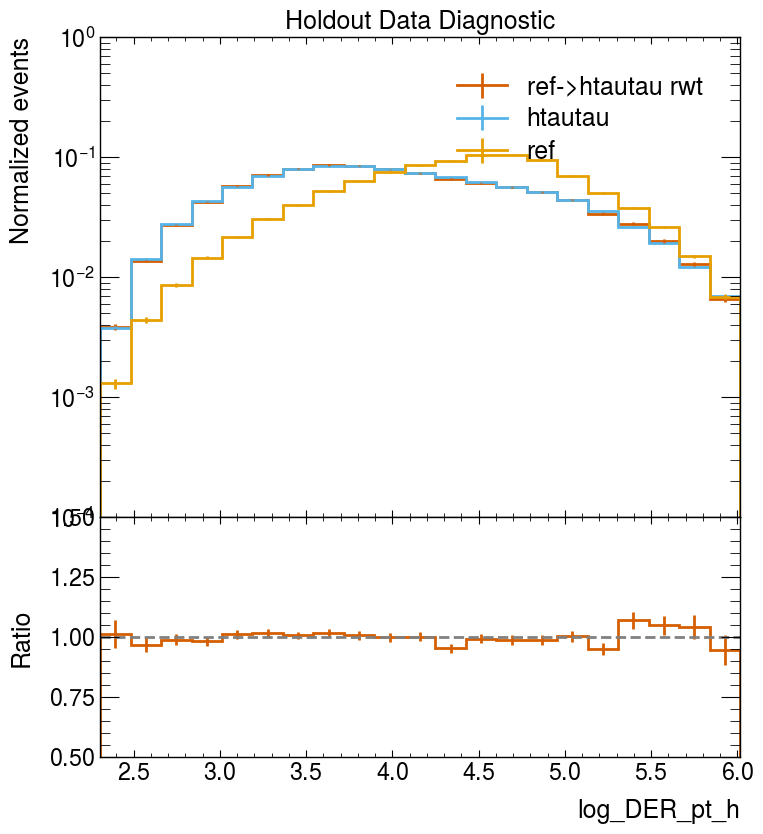

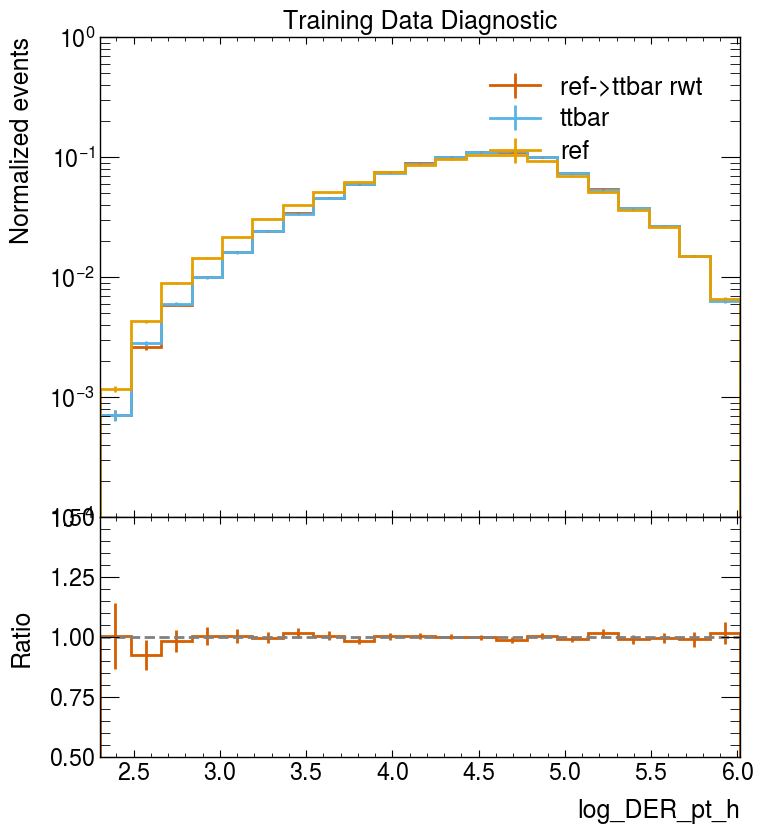

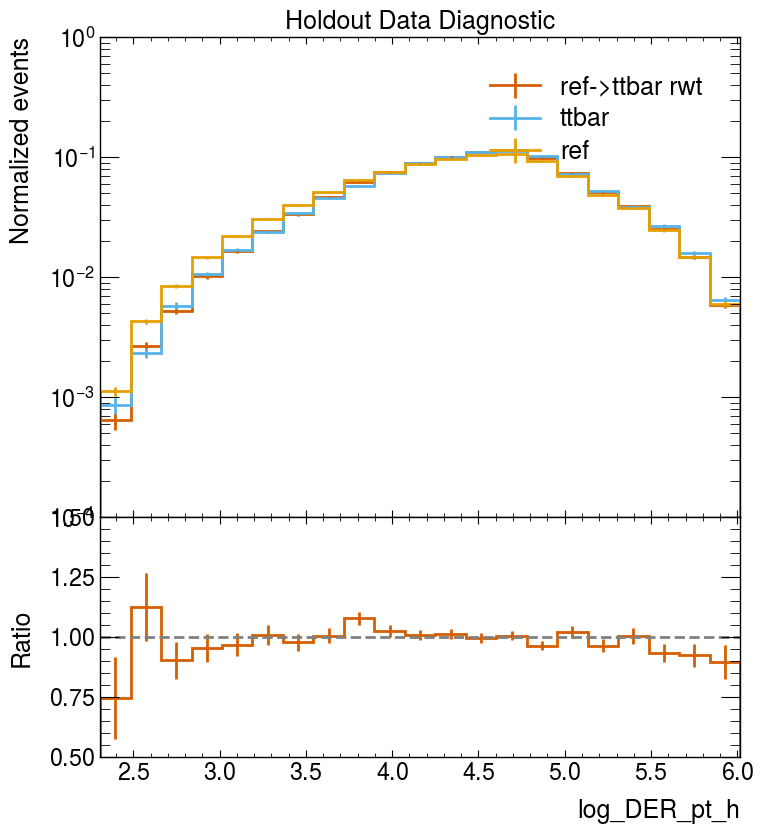

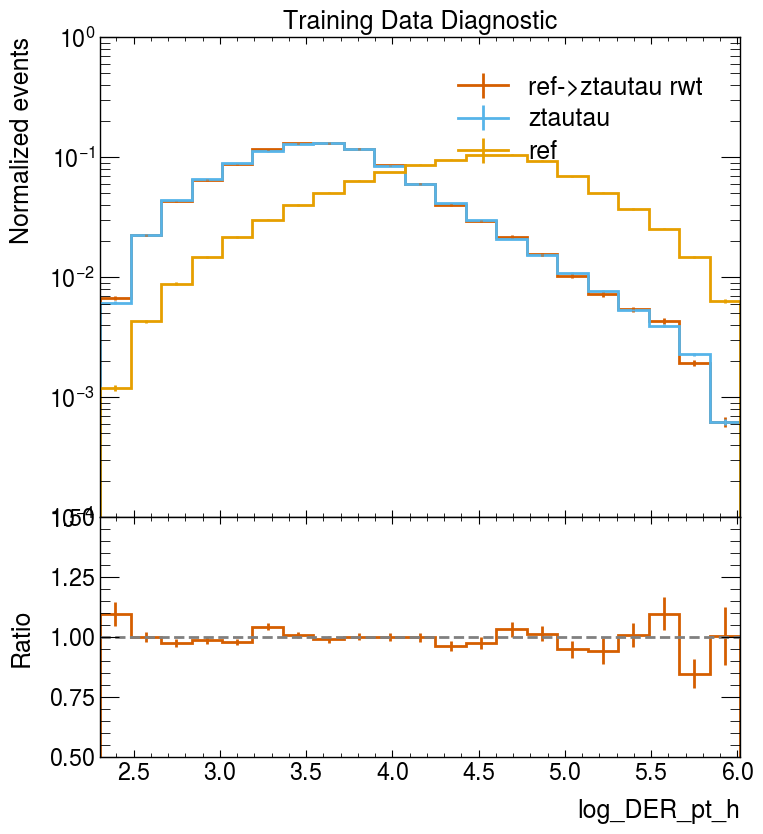

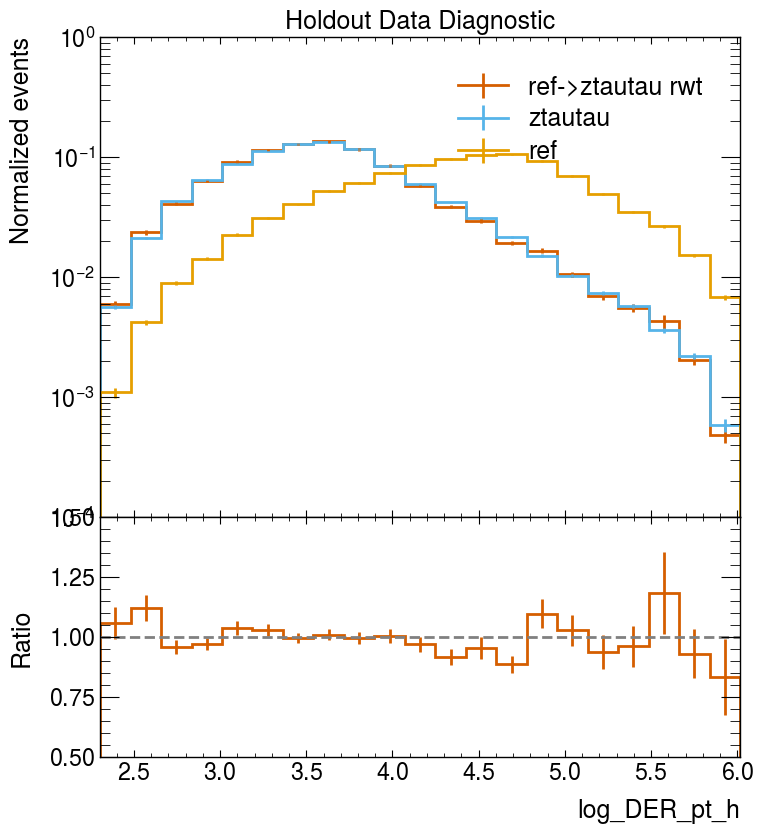

<Figure size 800x600 with 0 Axes>

In [13]:
variables_to_plot=['log_DER_pt_h'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

for process_type in basis_processes:

    NN_training_mix_model[process_type].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [14]:
dataset_combined_SR = Datasets.merge_dataframe_dict_for_training(dataset_SR_nominal, None, 
                                                                samples_to_merge = ["htautau", "ztautau", "ttbar"])

In [15]:
path_to_saved_ratios = {}

for process_type in basis_processes:
    # Evaluate the density ratios p_c/p_ref for the full dataset and save for the inference step
    path_to_saved_ratios[process_type] = NN_training_mix_model[process_type].evaluate_and_save_ratios(dataset_combined_SR, 
                                                                                                     aggregation_type = 'median_score')

Evaluating density ratios


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Evaluating density ratios


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Evaluating density ratios


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [16]:
path_to_saved_ratios

{'htautau': './saved_data/output_training_nominal/output_ratios_htautau/ratio_htautau.npy',
 'ttbar': './saved_data/output_training_nominal/output_ratios_ttbar/ratio_ttbar.npy',
 'ztautau': './saved_data/output_training_nominal/output_ratios_ztautau/ratio_ztautau.npy'}

In [ ]:
path_to_save = "saved_datasets/dataset_Asimov.root"
nsbi_common_utils.datasets.save_dataframe_as_root(dataset_combined_SR, 
                                                  path_to_save = path_to_save,
                                                  tree_name = "nominal")

In [ ]:
path_to_save = "saved_datasets/asimov_weights.npy"
np.save(f"{path_to_save}", dataset_combined_SR["weights"].to_numpy())

Systematic Uncertainty Modelling
===

So far we have left out the nuisance parameter piece of the parameterized density ratio decomposition shown before:

$$g_c(x|\alpha) = \frac{p_c(x|\alpha)}{p_c(x)}$$

which will be estimated in the `Systematic_Uncertainty_Estimation.ipynb` notebook.

Training an Ensemble of NNs
===

In a realistic analysis, a large ensemble of NNs are trained to estimate density ratios, for *each* of the channels. **This reduces not only the variance but has also been found to reduce biases in the final fits.**

In the off-shell Higgs boson analysis, we used k-fold cross-validation, with k=10, to train an ensemble $N_{ens}\sim 250$ of NNs per density ratio $p_c(x)/p_{ref}(x)$. The density ratios used in the final fit are always evaluated on the holdout dataset and by using each of the folds as holdout once, the entire model for $p_c(x)/p_{ref}(x)$ consists of $N_{ens}\times k \sim 2500$ NNs. Each NN in the ensemble is trained by resampling data without replacement from the k-1 folds used for training.
